#  Cigar data anaylisis

In [22]:
# S2 signal script
import sys
sys.path.append('/home/investigator/mariandbt/python/notebooks/modules')
sys.path.append('/scratch/marian/python/notebooks/modules')

from datetime import datetime
import matplotlib.dates as mdates  # Import for date formatting

from import_modules import *
import set_up as setup
import s2_simulation as s2sim

from scipy.optimize import curve_fit


import glob
import re

##  Functions

In [23]:
# Sort the files based on the number that appears right before the '.h5' extension
def extract_number_h5(file):
    # Extract the number before '.h5' using regex
    match = re.search(r'_(\d+)\.h5$', file)  # Matches '_number.h5'
    return int(match.group(1)) if match else float('inf')  # Extract the number or return 'inf'


In [24]:

CHAmp={
"CH1":535,
"CH2":537,
"CH3":684,
"CH4":675}

temp = 'room'

if temp == 'room':
    # Samuele's (20241025) RoomTemp
    ConvPar={
    "CH1":(2.75e-8,-6.32e-9), # V*s
    "CH2":(3.18e-8,-5.60e-9), # V*s
    "CH3":(3.58e-8,-3.49e-9), # V*s
    "CH4":(3.87e-8,-4.68e-9)  # V*s
    }

if temp == '14deg':
    # Marian's (20241022) 14deg
    ConvPar={
    "CH1":(3.26e-8,-7.32e-9), # V*s
    "CH2":(3.79e-8,-1.06e-8), # V*s
    "CH3":(4.44e-8,-1.03e-8), # V*s
    "CH4":(4.13e-8,-1.07e-8)  # V*s
    }

def ChargeToPes(integral, p0, p1):
    
#     integral is in V*us
    
    photoelectrons = (integral - p1) / p0
    return photoelectrons

# charge_in_pes = ChargeToPes(charge_in_Vus[f'CH{ii}']*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])

##  Data reading

In [25]:
# path = '/home/investigator/mariandbt/python/data'
path = '/scratch/marian/python/data'

path = path + '/cigar'

In [26]:
runs = {
#         1.5: '20241011_with_am_1.5bar_N_14.0deg_no_amp', # only CH1
#         2.5: '20241011_with_am_2.5bar_N_14.0deg_no_amp', 
#         3.5: '20241011_with_am_3.5bar_N_14.0deg_no_amp', 
#         4.5: '20241016_with_am_4.5bar_N_14.0deg_no_amp', 
#         5.5: '20241018_with_am_5.5bar_Ar_14.0deg_no_amp', # only CH1
#         6.5: '20241021_with_am_6.5bar_Ar_14.0deg_no_amp', 
#         6.5: '20241022_with_am_6.5bar_Ar_14.0deg_no_amp', 
#         6.5: '20241022_with_am_6.5bar_Ar_roomtemp_no_amp', 
#         7.5: '20241023_with_am_7.5bar_Ar_roomtemp_no_amp', 
#         7.5: '20241024_with_am_7.5bar_Ar_roomtemp_no_amp', 
#         8.2: '20241028_with_am_8.2bar_Ar_roomtemp_no_amp', 
#         8.5: '20241025_with_am_8.5bar_Ar_roomtemp_no_amp',
        8.5: '20241029_with_am_inside_8.5bar_Ar_roomtemp_no_amp',
        7.5: '20241030_with_am_inside_7.5bar_Ar_roomtemp_no_amp',
        6.5: '20241031_with_am_inside_6.5bar_Ar_roomtemp_no_amp',
        5.5: '20241104_with_am_inside_5.5bar_Ar_roomtemp_no_amp',
#         5.5: '20241104_with_am_inside_5.5bar_Ar_roomtemp_no_amp_run2', # Hot getter mostly off 
        4.5: '20241105_with_am_inside_4.5bar_Ar_roomtemp_no_amp',
        3.5: '20241106_with_am_inside_3.5bar_Ar_roomtemp_no_amp',
        2.5: '20241107_with_am_inside_2.5bar_Ar_roomtemp_no_amp',
        1.5: '20241108_with_am_inside_1.5bar_Ar_roomtemp_no_amp',
        1.0:'20241111_with_am_inside_1.0bar_Ar_roomtemp_no_amp'
       }

In [27]:
bars     = 4.5
run      = runs[bars]

run_path = os.path.join(path, run) 

# Use glob to find all .h5 files in the directory
h5_files = glob.glob(f"{run_path}/*.h5")
h5_files = sorted(h5_files, key=extract_number_h5)


In [28]:

# # 20241011_with_am_2.5bar_N_14.0deg_no_amp
# timetable = ['oct 14 17:03', 'oct 14 17:26', 'oct 14 17:50', 'oct 14 18:13', 'oct 14 18:35', 
#              'oct 14 18:58', 'oct 14 19:23', 'oct 14 19:47', 'oct 14 20:11', 'oct 14 20:36', 
#              'oct 14 20:59', 'oct 14 21:24', 'oct 14 21:50', 'oct 14 22:15', 'oct 14 22:41', 
#              'oct 14 23:06', 'oct 14 23:32', 'oct 14 23:59', 'oct 15 00:26', 'oct 15 00:52', 
#              'oct 15 01:17', 'oct 15 01:44', 'oct 15 02:10', 'oct 15 02:37', 'oct 15 03:03', 
#              'oct 15 03:31', 'oct 15 03:57', 'oct 15 04:23', 'oct 15 04:49', 'oct 15 05:15', 
#              'oct 15 05:40', 'oct 15 06:04', 'oct 15 06:29', 'oct 15 06:54', 'oct 16 09:34'] 


# # 20241017_with_am_5.5bar_Ar_14.0deg_no_amp
# timetable = ['oct 17 09:23', 'oct 17 09:41', 'oct 17 09:58', 'oct 17 10:16', 'oct 17 10:34', 
#              'oct 17 10:52', 'oct 17 11:10', 'oct 17 11:29', 'oct 17 11:47', 'oct 17 12:05', 
#              'oct 17 12:23', 'oct 17 12:41', 'oct 17 12:59', 'oct 17 13:18', 'oct 17 13:36', 
#              'oct 17 13:54', 'oct 17 14:12', 'oct 17 14:30', 'oct 17 14:48', 'oct 17 15:07', 
#              'oct 17 15:25', 'oct 17 15:43', 'oct 17 16:02', 'oct 17 16:20', 'oct 17 16:38', 
#              'oct 17 16:56', 'oct 17 17:14', 'oct 17 17:32', 'oct 17 17:50', 'oct 17 18:08', 
#              'oct 17 18:26', 'oct 17 18:44', 'oct 17 19:02', 'oct 17 19:20', 'oct 17 19:38', 
#              'oct 17 19:56', 'oct 17 20:13', 'oct 18 09:54']

# 20241031_with_am_inside_6.5bar_Ar_roomtemp_no_amp
# timetable = ['oct 31 10:09', 'oct 31 17:30']

# 20241104_with_am_inside_5.5bar_Ar_roomtemp_no_amp
# timetable = ['nov 4 9:30', 'nov 4 17:05']

# 20241104_with_am_inside_5.5bar_Ar_roomtemp_no_amp_run2
# timetable = ['nov 4 17:06', 'nov 4 23:39']

# 20241105_with_am_inside_4.5bar_Ar_roomtemp_no_amp
# timetable = ['nov 5 10:48', 'nov 5 17:39']


In [35]:
# Get the current year (or set it to a specific year)
current_year = datetime.now().year

# Convert to datetime objects with the current year
creation_time = [datetime.strptime(f'{current_year} {time}', '%Y %b %d %H:%M') for time in timetable]
# Convert the datetime.datetime objects to numpy.datetime64 with millisecond precision
creation_time = [np.datetime64(date, 's') for date in creation_time]


##  Data processing

In [30]:
channels = [1, 2, 3, 4]
# channels = [1]


In [36]:
creation_time


[numpy.datetime64('2024-10-14T17:03:00'),
 numpy.datetime64('2024-10-14T17:26:00'),
 numpy.datetime64('2024-10-14T17:50:00'),
 numpy.datetime64('2024-10-14T18:13:00'),
 numpy.datetime64('2024-10-14T18:35:00'),
 numpy.datetime64('2024-10-14T18:58:00'),
 numpy.datetime64('2024-10-14T19:23:00'),
 numpy.datetime64('2024-10-14T19:47:00'),
 numpy.datetime64('2024-10-14T20:11:00'),
 numpy.datetime64('2024-10-14T20:36:00'),
 numpy.datetime64('2024-10-14T20:59:00'),
 numpy.datetime64('2024-10-14T21:24:00'),
 numpy.datetime64('2024-10-14T21:50:00'),
 numpy.datetime64('2024-10-14T22:15:00'),
 numpy.datetime64('2024-10-14T22:41:00'),
 numpy.datetime64('2024-10-14T23:06:00'),
 numpy.datetime64('2024-10-14T23:32:00'),
 numpy.datetime64('2024-10-14T23:59:00'),
 numpy.datetime64('2024-10-15T00:26:00'),
 numpy.datetime64('2024-10-15T00:52:00'),
 numpy.datetime64('2024-10-15T01:17:00'),
 numpy.datetime64('2024-10-15T01:44:00'),
 numpy.datetime64('2024-10-15T02:10:00'),
 numpy.datetime64('2024-10-15T02:3

In [38]:
rundate   = []
std    = {'CH1': [], 'CH2':[], 'CH3':[], 'CH4':[]}
mean   = {'CH1': [], 'CH2':[], 'CH3':[], 'CH4':[]}
median = {'CH1': [], 'CH2':[], 'CH3':[], 'CH4':[]}
perc70 = {'CH1': [], 'CH2':[], 'CH3':[], 'CH4':[]}
perc90 = {'CH1': [], 'CH2':[], 'CH3':[], 'CH4':[]}

time_ticks = 6250
top_files  = -1
# top_files  = None

for ii, file in enumerate(h5_files[:top_files]):
    
    print(f'Processing... {file}' + ' '*20, end = '\r')
    
    df = pd.read_hdf(file)
    # date = pd.to_datetime(df.event_time, unit='s', utc = True).dt.tz_convert('Europe/Madrid')
    # rundate.append(date.mean())
    rundate = creation_time[ii]
    
#     print(date.min(), date.max())
    
    time = df["TIME"].to_numpy()[:time_ticks] # [s]
    
    for ii in channels:
    
        ch = df[f'CH{ii}'].to_numpy().reshape(-1, time_ticks)  # [V]

        # Peak correction
        inf_mask = np.isinf(ch)
        neg_inf_mask = np.isneginf(ch)

        ch[inf_mask] = ch[np.isfinite(ch)].max()
        ch[neg_inf_mask] = ch[np.isfinite(ch)].min()


        integration_window = (time > -3e-6) & (time < 9e-6)

        ch_area = np.trapz(ch[:, integration_window], time[integration_window], axis=1) # [V*s]

        # Calculate median and percentiles and std for each charge column while ignoring NaN values
        ch_std    = np.std(ch_area, axis=0)
        ch_mean   = np.mean(ch_area, axis=0)
        ch_median = np.median(ch_area, axis=0)
        ch_perc70 = np.quantile(ch_area, 0.70, axis=0)
        ch_perc90 = np.quantile(ch_area, 0.90, axis=0)


        std[f'CH{ii}'].append(ch_std)
        mean[f'CH{ii}'].append(ch_mean)
        median[f'CH{ii}'].append(ch_median)
        perc70[f'CH{ii}'].append(ch_perc70)
        perc90[f'CH{ii}'].append(ch_perc90)

for ii in channels:
    std[f'CH{ii}']    = np.array(std[f'CH{ii}'])
    mean[f'CH{ii}']   = np.array(mean[f'CH{ii}'])
    median[f'CH{ii}'] = np.array(median[f'CH{ii}'])
    perc70[f'CH{ii}'] = np.array(perc70[f'CH{ii}'])
    perc90[f'CH{ii}'] = np.array(perc90[f'CH{ii}'])


IndexError: list index out of range

#  Time profile

In [ ]:
n_entries = len(ch_area)
n_entries

In [ ]:
font_size = 20

pes = True

# run_time = creation_time[:top_files]

# Generate an array of 50 equally spaced datetime64 values between the two dates
# timedelta = (creation_time[top_files] - creation_time[0])/(len(h5_files[:top_files]))
# run_time = np.arange(creation_time[0], creation_time[top_files] + timedelta, timedelta)
# run_time = run_time[:len(h5_files[:top_files])]


In [ ]:
# run_time = [np.datetime64(date, 's') for date in rundate]
run_time = rundate

In [20]:
len(run_time), len(h5_files[:top_files])

(46, 46)

##  Mean 

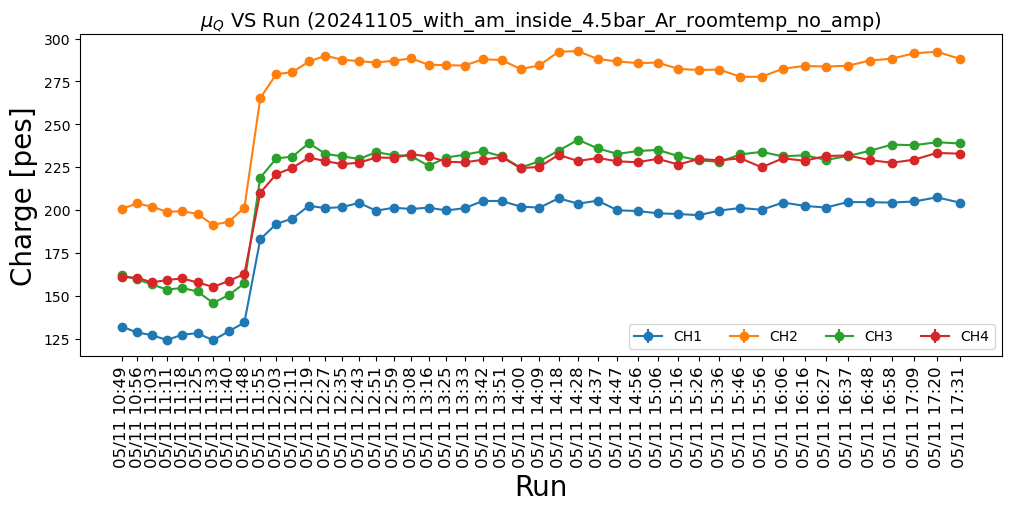

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)


# Loop over all columns in the dataframe that start with 'CH'
for ii in channels:
        
    std_value  = std[f'CH{ii}'] # [V*s]
    mean_value = mean[f'CH{ii}'] # [V*s]

    if pes:
        std_value  = ChargeToPes(std_value*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])
        mean_value = ChargeToPes(mean_value*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])

    mean_error = std_value/np.sqrt(n_entries)

    ax.errorbar(run_time, mean_value, yerr = mean_error, fmt = 'o-', label = f'CH{ii}')


# Set x-ticks without rotation first
ax.set_xticks(run_time)
# Use DateFormatter to show just the day and hour on x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M', tz='Europe/Madrid')
ax.xaxis.set_major_formatter(date_format)
# Accessing and printing the current tick labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='center', fontsize = 12)
    
ax.set_title(fr'$\mu_Q$ VS Run ({run})', fontsize = 0.7*font_size);
ax.set_xlabel('Run', fontsize = font_size);

if pes:
    ax.set_ylabel(r'Charge [pes]', fontsize = font_size);
else:
    ax.set_ylabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);

# ax.set_ylim(0.9e-3, 2.2e-3)

ax.legend(ncol = 4, loc = 'best')

##  Median 

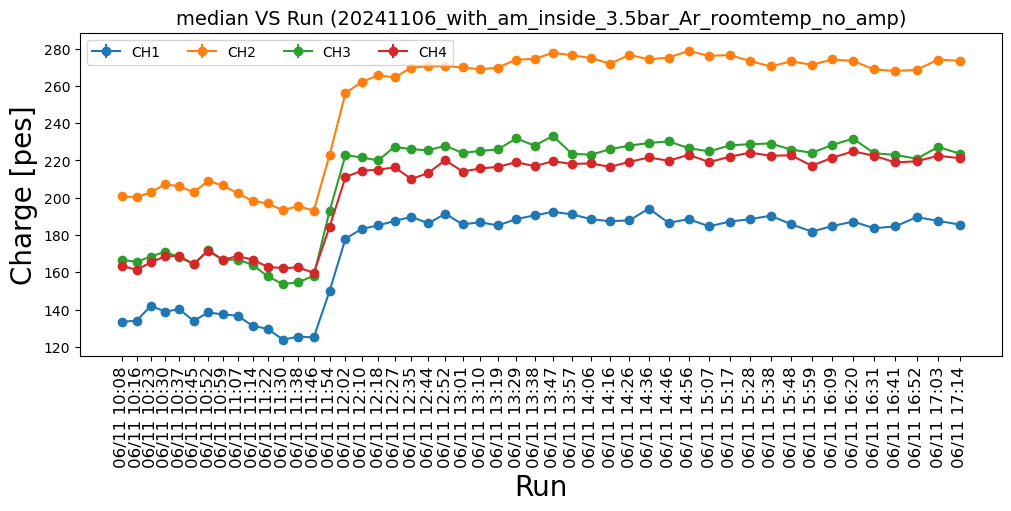

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)


# Loop over all columns in the dataframe that start with 'CH'
for ii in channels:
        
    std_value  = std[f'CH{ii}'] # [V*s]
    median_value = median[f'CH{ii}'] # [V*s]

    if pes:
        std_value  = ChargeToPes(std_value*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])
        median_value = ChargeToPes(median_value*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])

    median_error = 1.2533*std_value/np.sqrt(n_entries)

    ax.errorbar(run_time, median_value, yerr = median_error, fmt = 'o-', label = f'CH{ii}')


# Set x-ticks without rotation first
ax.set_xticks(run_time)
# Use DateFormatter to show just the day and hour on x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M', tz='Europe/Madrid')
ax.xaxis.set_major_formatter(date_format)
# Accessing and printing the current tick labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='center', fontsize = 12)
    
ax.set_title(fr'median VS Run ({run})', fontsize = 0.7*font_size);
ax.set_xlabel('Run', fontsize = font_size);

if pes:
    ax.set_ylabel(r'Charge [pes]', fontsize = font_size);
else:
    ax.set_ylabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);

# ax.set_ylim(0.9e-3, 2.2e-3)

ax.legend(ncol = 4, loc = 'best')

##  70 percentile 

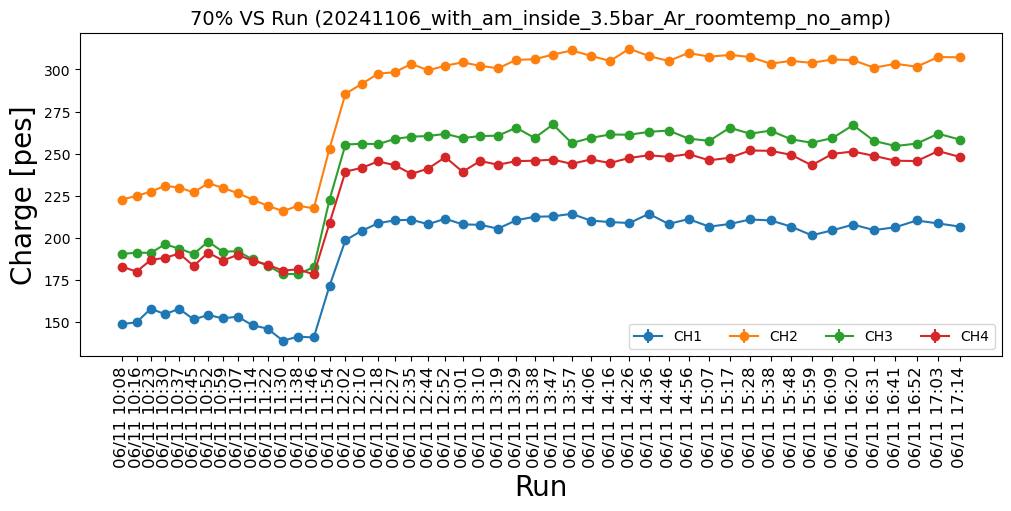

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)


# Loop over all columns in the dataframe that start with 'CH'
for ii in channels:
        
    std_value  = std[f'CH{ii}'] # [V*s]
    perc70_value = perc70[f'CH{ii}'] # [V*s]

    if pes:
        std_value  = ChargeToPes(std_value*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])
        perc70_value = ChargeToPes(perc70_value*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])

    perc70_error = 0.524*std_value/np.sqrt(n_entries)

    ax.errorbar(run_time, perc70_value, yerr = perc70_error, fmt = 'o-', label = f'CH{ii}')


# Set x-ticks without rotation first
ax.set_xticks(run_time)
# Use DateFormatter to show just the day and hour on x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M', tz='Europe/Madrid')
ax.xaxis.set_major_formatter(date_format)
# Accessing and printing the current tick labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='center', fontsize = 12)
    
ax.set_title(fr'70% VS Run ({run})', fontsize = 0.7*font_size);
ax.set_xlabel('Run', fontsize = font_size);

if pes:
    ax.set_ylabel(r'Charge [pes]', fontsize = font_size);
else:
    ax.set_ylabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);

# ax.set_ylim(0.9e-3, 2.2e-3)

ax.legend(ncol = 4, loc = 'best')

##  90 percentile 

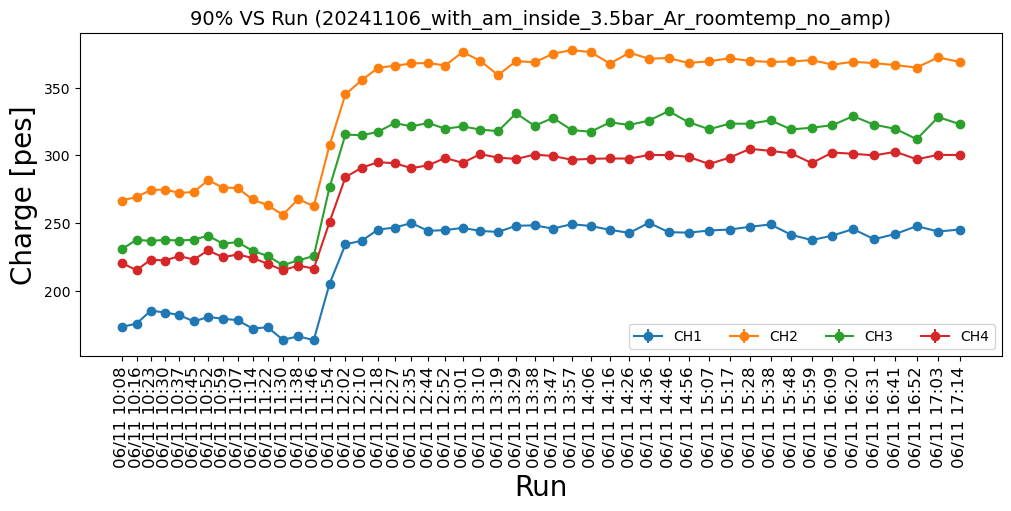

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)


# Loop over all columns in the dataframe that start with 'CH'
for ii in channels:
        
    std_value  = std[f'CH{ii}'] # [V*s]
    perc90_value = perc90[f'CH{ii}'] # [V*s]

    if pes:
        std_value  = ChargeToPes(std_value*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])
        perc90_value = ChargeToPes(perc90_value*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])

    perc90_error = 1.282*std_value/np.sqrt(n_entries)

    ax.errorbar(run_time, perc90_value, yerr = perc90_error, fmt = 'o-', label = f'CH{ii}')


# Set x-ticks without rotation first
ax.set_xticks(run_time)
# Use DateFormatter to show just the day and hour on x-axis
date_format = mdates.DateFormatter('%d/%m %H:%M', tz='Europe/Madrid')
ax.xaxis.set_major_formatter(date_format)
# Accessing and printing the current tick labels
plt.setp(ax.get_xticklabels(), rotation=90, ha='center', fontsize = 12)
    
ax.set_title(fr'90% VS Run ({run})', fontsize = 0.7*font_size);
ax.set_xlabel('Run', fontsize = font_size);

if pes:
    ax.set_ylabel(r'Charge [pes]', fontsize = font_size);
else:
    ax.set_ylabel(r'Charge [V $\cdot$ $\mu$ s]', fontsize = font_size);

# ax.set_ylim(0.9e-3, 2.2e-3)

ax.legend(ncol = 4, loc = 'best')